#Channel Comparison#
Here we compare the gate kinetics for each of the channels used in the AOB mitral cell model in Zybertal et al. 2015 versus Gorin et al. 2016.

##Passive Parameters##

    'e_pas': -50.374625040653285,                 # leak channels equilibrium potential - Eleak (mV)
    'ek': -87.442393003543842,                    # K+ equilibrium potential - Ek (mV)
    'ena': 59.251437490569053,                    # initial Na+ equilibrium potential - ENa (mV)
    'rm': 69120.845688267262                      # specific membrane resistance with respect to leak - rm (ohm*cm^2)
    
    'ras':{'apic1': 217.31426241951729,           # axial resistance of each compartment, 
    'apic2': 399.99640279865821,                           based on geometry lumping step (ohm*cm)
    'axon': 58.8366908030129,
    'basl': 63.032089044574661,
    'hlck': 58.8366908030129,
    'iseg': 58.8366908030129,
    'soma': 17.936577064084748,
    'tuft1': 81.196148904926218,
    'tuft2': 44.109855426282152},
    
    'dendfactor': 1.0999812070427781,             # global dendritic surface area multiplier - DF

##Leak Currents##
    
    # calculate leak conductance, use dendfactor for all processes
                if sec==self.soma:
                    sec_g=1./params['rm']
                else:
                    sec_g=params['dendfactor']/params['rm']
                
    # use K+ equilibrium potential, initial Na+ equilibrium potential and leak reversal potential to divide leak        conductance between K+ and Na+
                seg.g_kleak=sec_g/(1+((params['ek']-params['e_pas'])/(params['e_pas']-params['ena'])))
                seg.g_naleak=sec_g-seg.g_kleak

    self.soma.cm=1.0        # Soma capacitance is 1 uF/cm^2
    sec.cm=1 * params['dendfactor'] # capacitance is 1 uF/cm^2 * dendfactor
    ik = g * (v - ek)
    i = g * (v - ena)

##Sodium Diffusion and Pump##
: Sodium ion accumulation with radial and longitudinal diffusion, buffering and pumping


NEURON {
    SUFFIX nadp
    USEION na READ nao, nai, ina WRITE nai, ina, ena
    NONSPECIFIC_CURRENT ik_pump
    RANGE ina_pmp, TotalPump, ik_ratio, na, pump, pumpna
    GLOBAL vrat, DNa, k1, k2, k3, k4
                                                           
}

DEFINE Nannuli 4

UNITS {
    (molar) = (1/liter)
    (mM) = (millimolar)
    (um) = (micron)
    (mA) = (milliamp)
    (mV) = (millivolt)
    FARADAY = (faraday) (10000 coulomb)
    R = (k-mole) (joule/degC)    
    PI = (pi) (1)
    (mol) = (1)

}

PARAMETER {

    DNa = 0.6 (um2/ms)

    k1 = 1.0 (/mM3-ms)

    k2 = 0.001 (/ms)
    
    k3 = 0.3 (/ms)
                            : to eliminate pump, set TotalPump to 0 in hoc
    TotalPump = 1e-14 (mol/cm2)
    
    ik_ratio = -0.66666666 (1)

}

ASSIGNED {
    diam (um)
    L (um)
    ina (mA/cm2)
    nai (mM)
    vrat[Nannuli] : numeric value of vrat[i] equals the volume
                 : of annulus i of a 1um diameter cylinder
                 : multiply by diam^2 to get volume per um length
    
    k4          (/mM3-ms)

    nao (mM)
    ena (mV)

    ina_pmp (mA/cm2)
    parea (um)

    ik_pump (mA/cm2)



}

CONSTANT { volo = 1e10 (um2) }

STATE {
    : na[0] is equivalent to nai
    na[Nannuli] (mM) <1e-3>

    pump (mol/cm2)
    pumpna (mol/cm2)

}


BREAKPOINT {


    SOLVE state METHOD sparse

    ina = ina_pmp
    ik_pump = ik_ratio*ina_pmp

}

LOCAL factors_done

INITIAL {

    k4=(((nai/nao)^3)*k1*k3)/k2    :Set the equilibrium at nai0_na_ion
    parea = PI*diam
    pump = TotalPump/(1 + (nai*k1/k2))
    pumpna = TotalPump - pump
    if (factors_done == 0) {    : flag becomes 1 in the first segment
        factors_done = 1        : all subsequent segments will have
        factors()               : vrat = 0 unless vrat is GLOBAL
    }

    FROM i=0 TO Nannuli-1 {
        na[i] = nai

    }

}

LOCAL frat[Nannuli]     : scales the rate constants for model geometry

PROCEDURE factors() {
    LOCAL r, dr2
    r = 1/2                 : starts at edge (half diam)
    dr2 = r/(Nannuli-1)/2   : full thickness of outermost annulus,
                            : half thickness of all other annuli
    vrat[0] = 0
    frat[0] = 2*r
    FROM i=0 TO Nannuli-2 {
        vrat[i] = vrat[i] + PI*(r-dr2/2)*2*dr2  : interior half
        r = r - dr2
        frat[i+1] = 2*PI*r/(2*dr2)              : outer radius of annulus
                                                : div by distance between centers
        r = r - dr2
        vrat[i+1] = PI*(r+dr2/2)*2*dr2 : outer half of annulus
    }
}


KINETIC state {
    COMPARTMENT i, diam*diam*vrat[i] {na}
    COMPARTMENT (1e10)*parea {pump pumpna}
    COMPARTMENT volo {nao}

    LONGITUDINAL_DIFFUSION i, DNa*diam*diam*vrat[i] {na}

    :pump
    ~ 3 na[0] + pump <-> pumpna (k1*parea*(1e10), k2*parea*(1e10))
    ~ pumpna <-> pump + 3 nao (k3*parea*(1e10), k4*parea*(1e10))

    CONSERVE pump + pumpna = TotalPump * parea * (1e10)
    ina_pmp = FARADAY*(f_flux - b_flux)/parea

    : all currents except pump
    ~ na[0] << (-(ina-ina_pmp)*PI*diam/(FARADAY)) : ina is Na efflux

    FROM i=0 TO Nannuli-2 {
        ~ na[i] <-> na[i+1] (DNa*frat[i+1], DNa*frat[i+1])
    }
    nai = na[0]
    ena = ((R*(273.15+celsius))/(FARADAY*10))*log(nao/nai)
}

##Calcium Pool with buffering, Diffusion and Pump##
: Calcium ion accumulation with radial diffusion, buffering and pumping

NEURON {
    SUFFIX cadp
    USEION ca READ cao, cai, ica WRITE cai, ica
    RANGE ica_pmp, ex_buffer_ratio, f, AvgCaExBuffer, diam_factor, TotalPump, ca, CaEndBuffer, EndBuffer, CaExBuffer, ExBuffer, pump, pumpca
    GLOBAL vrat, TotalEndBuffer, TotalExBuffer, k1, k2, k3, k4, k1bufend, k2bufend, k1bufex, k2bufex, DCa, fl_ratio, dep_factor
    USEION dep READ depi VALENCE 1

    NONSPECIFIC_CURRENT icont                                                       
}

DEFINE Nannuli 4

UNITS {
    (molar) = (1/liter)
    (mM) = (millimolar)
    (um) = (micron)
    (mA) = (milliamp)
    FARADAY = (faraday) (10000 coulomb)
    PI = (pi) (1)
    (mol) = (1)

}

PARAMETER {

    DCa = 0.6 (um2/ms)
    k1bufend = 100 (/mM-ms) : Yamada et al. 1989
    k2bufend = 0.1 (/ms)
    TotalEndBuffer = 0.003 (mM)

    k1bufex = 100 (/mM-ms) 
    k2bufex = 0.017 (/ms)       :   Based on OGB-1 kd
    TotalExBuffer = 0.04 (mM)   : 

    k1 = 1 (/mM-ms)
    
    k3 = 1 (/ms)
                            : to eliminate pump, set TotalPump to 0 in hoc
    TotalPump = 1e-14 (mol/cm2)

    fl_ratio=14 (1)

    diam_factor=1 (1)
    dep_factor=1 (1)


}

ASSIGNED {
    diam (um)
    L (um)
    ica (mA/cm2)
    cai (mM)
    vrat[Nannuli] : numeric value of vrat[i] equals the volume
                 : of annulus i of a 1um diameter cylinder
                 : multiply by diam^2 to get volume per um length
    
    depi
    k2          (/ms)
    k4          (/mM-ms)

    ka_end (/mM)
    ka_ex (/mM)

    B0end (mM)
    B0ex (mM)

    cao (mM)
    ica_pmp (mA/cm2)
    icont (mA/cm2)
    parea (um)
    AvgCaExBuffer (mM)  : [CaExBuffer] averaged over all shells.

    f    (1)
    diamf   (um)


}

CONSTANT { volo = 1e10 (um2) }

STATE {
    : ca[0] is equivalent to cai
    : ca[] are very small, so specify absolute tolerance
    ca[Nannuli] (mM) <1e-10>
    CaEndBuffer[Nannuli] (mM)
    EndBuffer[Nannuli] (mM)
    CaExBuffer[Nannuli] (mM)
    ExBuffer[Nannuli] (mM)

    pump (mol/cm2)
    pumpca (mol/cm2)

}


BREAKPOINT {


    SOLVE state METHOD sparse

    ica = ica_pmp
    icont = -ica_pmp
    AvgCaExBuffer = 0.0
    
    FROM i=0 TO Nannuli-1 {
        AvgCaExBuffer = AvgCaExBuffer + (CaExBuffer[i] * vrat[i])
    }

    AvgCaExBuffer = AvgCaExBuffer * (4/PI)
    f = TotalExBuffer + (fl_ratio - 1) * AvgCaExBuffer
    
}

LOCAL factors_done

INITIAL {

    k2=sqrt(cai/cao)    :Set the equilibrium at cai0_ca_ion
    k4=sqrt(cai/cao)
    diamf=diam*diam_factor

    parea = PI*diamf
    pump = TotalPump/(1 + (cai*k1/k2))
    pumpca = TotalPump - pump
    if (factors_done == 0) {    : flag becomes 1 in the first segment
        factors_done = 1        : all subsequent segments will have
        factors()               : vrat = 0 unless vrat is GLOBAL
    }

    ka_end = k1bufend/k2bufend
    ka_ex = k1bufex/k2bufex

    B0end = TotalEndBuffer/(1 + ka_end*cai)
    B0ex = TotalExBuffer/(1 + ka_ex*cai)

:    ex_buffer_ratio = 0.0
    FROM i=0 TO Nannuli-1 {
        ca[i] = cai
        EndBuffer[i] = B0end
        CaEndBuffer[i] = TotalEndBuffer - B0end
        ExBuffer[i] = B0ex
        CaExBuffer[i] = TotalExBuffer - B0ex
        :ex_buffer_ratio = ex_buffer_ratio + (CaExBuffer[i] * vrat[i])

    }
    :ex_buffer_ratio=(ex_buffer_ratio/(PI/4))/(TotalExBuffer - (ex_buffer_ratio/(PI/4)))


}

LOCAL frat[Nannuli]     : scales the rate constants for model geometry

PROCEDURE factors() {
    LOCAL r, dr2
    r = 1/2                 : starts at edge (half diam)
    dr2 = r/(Nannuli-1)/2   : full thickness of outermost annulus,
                            : half thickness of all other annuli
    vrat[0] = 0
    frat[0] = 2*r
    FROM i=0 TO Nannuli-2 {
        vrat[i] = vrat[i] + PI*(r-dr2/2)*2*dr2  : interior half
        r = r - dr2
        frat[i+1] = 2*PI*r/(2*dr2)              : outer radius of annulus
                                                : div by distance between centers
        r = r - dr2
        vrat[i+1] = PI*(r+dr2/2)*2*dr2 : outer half of annulus
    }
}

LOCAL dsq, dsqvol   : can't define local variable in KINETIC block
                    : or use in COMPARTMENT statement

KINETIC state {
    COMPARTMENT i, diamf*diamf*vrat[i] {ca CaIndBuffer IndBuffer CaExBuffer ExBuffer}
    COMPARTMENT (1e10)*parea {pump pumpca}
    COMPARTMENT volo {cao}

    :LONGITUDINAL_DIFFUSION i, DCa*diamf*diamf*vrat[i] {ca}

    :pump
    ~ ca[0] + pump <-> pumpca (k1*(1-depi*dep_factor)*parea*(1e10), k2*(1-depi*dep_factor)*parea*(1e10))
    ~ pumpca <-> pump + cao (k3*(1-depi*dep_factor)*parea*(1e10), k4*(1-depi*dep_factor)*parea*(1e10))

    CONSERVE pump + pumpca = TotalPump * parea * (1e10)
    ica_pmp = 2*FARADAY*(f_flux - b_flux)/parea

    : all currents except pump
    ~ ca[0] << (-(ica-ica_pmp)*PI*diamf/(2*FARADAY)) : ica is Ca efflux

    FROM i=0 TO Nannuli-2 {
        ~ ca[i] <-> ca[i+1] (DCa*frat[i+1], DCa*frat[i+1])
    }
    dsq = diamf*diamf
    FROM i=0 TO Nannuli-1 {
        dsqvol = dsq*vrat[i]
        ~ ca[i] + EndBuffer[i] <-> CaEndBuffer[i] (k1bufend*dsqvol, k2bufend*dsqvol)
        ~ ca[i] + ExBuffer[i] <-> CaExBuffer[i] (k1bufex*dsqvol, k2bufex*dsqvol)

    }
    cai = ca[0]
}

##Sodium Calcium Exchange##
TITLE sodium calcium exchange
: taken from Courtemanche et al Am J Physiol 1998 275:H301

NEURON {
	SUFFIX ncx
	USEION ca READ cao, cai WRITE ica
	USEION na READ nao, nai WRITE ina
	RANGE ica, ina , itot, imax, rate
	GLOBAL kna, kca, gamma, cont_factor, ksat, naf, is_fixed
    NONSPECIFIC_CURRENT icont
}

UNITS {
	(mA) = (milliamp)
	(mV) = (millivolt)
	F = (faraday) (coulombs)
	R 	= (k-mole)	(joule/degC)
}

PARAMETER {
	imax	= 3.2       (mA/cm2)
	kna	=  87.5     (mM)
	kca	=  1.38     (mM)
	gamma	= .35		: voltage dependence factor
    cont_factor = -1    (1)
    ksat = 0.1          (1)
    naf = 15.0      (mM)
    is_fixed = 0        (1)
}

ASSIGNED {
	celsius	(degC)
	v	(mV)
	ica	(mA/cm2)
	ina	(mA/cm2)
	itot	(mA/cm2)
    icont   (mA/cm2)
    rate    (mA/cm2)
	cao	(mM)
    cai	(mM)
	nao	(mM)
	nai	(mM)
}

BREAKPOINT {
	:LOCAL rate
    if (is_fixed==0) {
        rate = pumprate(v,nai,nao,cai,cao)
    }
    if (is_fixed==1) {
        rate = pumprate(v,naf,nao,cai,cao)
    }
	ina =  3*rate
	ica = -2*rate
	itot=ina+ica
    icont=itot*cont_factor
}

FUNCTION pumprate(v,nai,nao,cai,cao) {
	LOCAL q10, Kqa, KB, k
	k = R*(celsius + 273.14)/(F*1e-3)
	q10 = 3^((celsius - 37)/10 (degC))
	Kqa = exp(gamma*v/k)
	KB = exp( (gamma - 1)*v/k)
	pumprate = q10*imax*(Kqa*nai*nai*nai*cao-KB*nao*nao*nao*cai)/((kna*kna*kna + nao*nao*nao)*(kca + cao)*(1 + ksat*KB))
}

##Transient Sodium##
Sodium channel, Hodgkin-Huxley style kinetics.  

Kinetics were fit to data from Huguenard et al. (1988) and Hamill et
al. (1991)

qi is not well constrained by the data, since there are no points
between -80 and -55.  So this was fixed at 5 while the thi1,thi2,Rg,Rd
were optimized using a simplex least square proc

voltage dependencies are shifted approximately from the best
fit to give higher threshold

Author: Zach Mainen, Salk Institute, 1994, zach@salk.edu

2002 Modification of original channel to allow variable time step and to correct an initialization error.
Done by Michael Hines(michael.hines@yale.e) and Ruggero Scorcioni(rscorcio@gmu.edu) at EU Advance Course in Computational Neuroscience. Obidos, Portugal

May 2006: set the tha -28 mV, vshift 0 and thinf -55 mV to comply with measured 
Somatic Na+ kinetics in neocortex. Kole, ANU, 2006

	SOLVE states METHOD cnexp
    gna = gbarfactor*tadj*gbar*m*m*m*h
	ina = gna * (v - ena)

    a = 0.182 * (v+28) / (1 - exp(-(v+28)/9))
    b = 0.124 * (-v-28) / (1 - exp(-(-v-28)/9))

tadj = 2.3^((23 - 23)/10) // Celcius set to 23 therefore tadj = 1

mtau = 1/1/(a+b)
	if (mtau<1e-7) {mtau=1e-7}

minf = a/(a+b)

    a = 0.024 * (v+50) / (1 - exp(-(v+50)/5))
    b = 0.0091 * (-v - 75) / (1 - exp(-(-v - 75)/5))

htau = 1/tadj/(a+b)
    if (htau<1e-7) {htau=1e-7}

hinf = 1/(1+exp((v+55)/6.2))



FUNCTION trap0(v,th,a,q) {
	if (fabs(v/v1/2) > 1e-6) {
	        trap0 = a * (v - th) / (1 - exp(-(v - th)/q))
	} else {
	        trap0 = a * q
 	}
}	


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


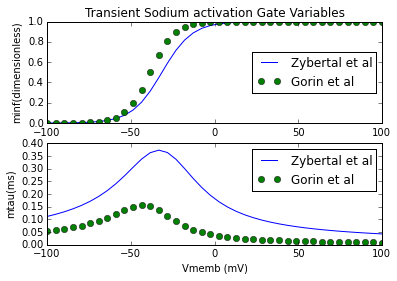

In [4]:
#load python packages
%pylab inline

#load equations
v = np.linspace(-100, 100, 40)
q10 = 2.1435469250725863 #= 2**((35-24)/10)
vhalf = -30
scale = 7.2
alpha = np.array(2.880000018*((v-vhalf)/scale)/(1 - np.exp(-((v-vhalf)/scale))))
beta = np.array(0.892800005*((v-vhalf)/-scale)/(1 - np.exp(-((v-vhalf)/-scale))))
tau = np.array(1/(alpha + beta))
testtau =np.array(1/((alpha + beta)*2.1435469250725863))
np.column_stack((v,alpha,beta,tau, testtau))

for i, value in enumerate(v):
    if "testtau" < 0.02:
        tau[i] =  (0.02*2.1435469250725863) 
    else:
        tau[i] =  tau[i]
        
mtaueq = tau/q10
minf_fit = alpha/(alpha + beta)

a = 0.182*(v+28) / (1 - exp(-(v+28)/9)) 
b = 0.124*(-v-28) / (1 - exp(-(-v-28)/9))
mtau = 1/1/(a+b)
minf = a/(a+b)

#plot Gate Variables
subplot(2,1,1)
plt.plot(v, minf, v, minf_fit, 'o')
plt.ylabel('minf(dimensionless)')
plt.title('Transient Sodium activation Gate Variables')
plt.legend(['Zybertal et al', 'Gorin et al'], loc='center right')
subplot(2,1,2)
plt.plot(v, mtau, v, mtaueq, 'o')
plt.xlabel('Vmemb (mV)')
plt.ylabel('mtau(ms)')
plt.legend(['Zybertal et al', 'Gorin et al'], loc='upper right')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


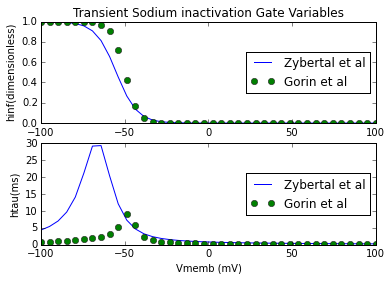

In [5]:
#load python packages
%pylab inline

#load equations
v = np.linspace(-100, 100, 40)
#q10 = 2**((35-24)/10)
vhalf = -45
scale = 1.5
alpha = np.array(0.045*((v-vhalf)/scale)/(1 - np.exp(-((v-vhalf)/scale))))
beta = np.array(0.015*((v-vhalf)/-scale)/(1 - np.exp(-((v-vhalf)/-scale))))
tau = np.array(1/(alpha + beta))
testtau =np.array(1/((alpha + beta)*2.1435469250725863))
np.column_stack((v,alpha,beta,tau,testtau))

for i, value in enumerate(v):
    if "testtau" < 0.5:
        tau[i] =  (0.5*2.1435469250725863) 
    else:
        tau[i] =  tau[i]
        
htaueq = tau/2.1435469250725863
hinf_fit = 1/(1 + np.exp(0.25*(v+50)))

a = 0.024 * (v+50) / (1 - exp(-(v+50)/5))
b = 0.0091 * (-v - 75) / (1 - exp(-(-v - 75)/5))
htau = 1/1/(a+b)
hinf = 1/(1+exp((v+55)/6.2))

#plot Gate Variables
subplot(2,1,1)
plt.plot(v, hinf, v, hinf_fit, 'o')
plt.ylabel('hinf(dimensionless)')
plt.title('Transient Sodium inactivation Gate Variables')
plt.legend(['Zybertal et al', 'Gorin et al'], loc='center right')
subplot(2,1,2)
plt.plot(v, htau, v, htaueq, 'o')
plt.xlabel('Vmemb (mV)')
plt.ylabel('htau(ms)')
plt.legend(['Zybertal et al', 'Gorin et al'], loc='center right')

##KFast##
Potassium channel, Hodgkin-Huxley style kinetics
Kinetic rates based roughly on Sah et al. and Hamill et al. (1991)
Author: Zach Mainen, Salk Institute, 1995, zach@salk.edu
2002 Modification of original channel to allow variable time step and to correct an initialization error.
Done by Michael Hines(michael.hines@yale.e) and Ruggero Scorcioni(rscorcio@gmu.edu) at EU Advance Course in Computational Neuroscience. Obidos, Portugal

        a = 0.02 * (v - 25) / (1 - exp(-(v - 25)/9))
        b = -0.002 * (v - 25) / (1 - exp((v - 25)/9))

        tadj = 2.3^((celsius - 23)/10) // Celcius set to 23 therefore tadj = 1
        ntau = 1/tadj/(a+b)
	if (ntau<1e-7) {
		ntau=1e-7
	}
	ninf = a/(a+b)

Populating the interactive namespace from numpy and matplotlib


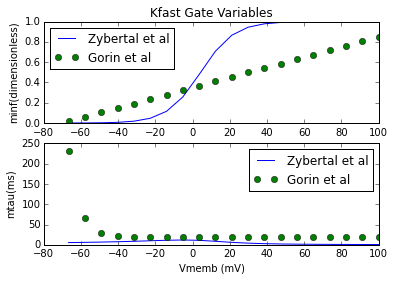

In [1]:
#load python packages
%pylab inline
import pandas as pd

#load equations
v = np.linspace(-66.67, 100, 20)
vhalf = 55
scale = 5.8842
mtaueq = 29.156*(np.exp(-(v+vhalf)/scale)) + 18.394
minf_fit = 0.005*v + 0.35

a = 0.02 * (v - 25) / (1 - exp(-(v - 25)/9))
b = -0.002 * (v - 25) / (1 - exp((v - 25)/9))
ntau = 1/1/(a+b)
ninf = a/(a+b)

#plot Gate Variables
subplot(2,1,1)
plt.plot(v, ninf, v, minf_fit, 'o')
plt.ylabel('minf(dimensionless)')
plt.title('Kfast Gate Variables')
plt.legend(['Zybertal et al', 'Gorin et al'], loc='upper left')
subplot(2,1,2)
plt.plot(v, ntau, v, mtaueq, 'o')
plt.xlabel('Vmemb (mV)')
plt.ylabel('mtau(ms)')
plt.legend(['Zybertal et al', 'Gorin et al'], loc='upper right')

##Kslow##

voltage gated potassium channel, Hodgkin-Huxley style kinetics.  

Kinetics were fit to data from recordings of nucleated patches derived 
from pyramidal neurons. Data recordings and fits from Alon Korngreen 

Author: Alon Korngreen,  MPImF Cell Physiology, 1998,
alon@mpimf-heidelberg.mpg.de

last updated 31/7/2002 by AK

BREAKPOINT {
        SOLVE states METHOD cnexp
        gk = tadj*gbar*a*a*(0.5*b+0.5*b1)
	  ik = gk * (v - ek)
} 

tadj = 2.3^((23 - 21)/10)
	
alpha=0.0052*(v-11.1)/(1-exp(-(v-11.1)/13.1))
beta=0.01938*exp(-(v+1.27)/71)-0.0053

taua=1/(alpha+beta)
    if (taua<1e-7) {
	taua=1e-7
    }
ainf = alpha/(alpha+beta)
	
taub = 360 + (1010+23.7*(v+54))*exp(-(v+75)*(v+75)/(48*48))
	if (taub<1e-7) {
		taub=1e-7
	}
taub1=2350+1380*exp(-0.01118*v)-210*exp(-0.0306*v)
	if (taub1<1e-7) {
		taub1=1e-7
	}
binf = 1/(1+exp(-(v+58)/-11))

Populating the interactive namespace from numpy and matplotlib


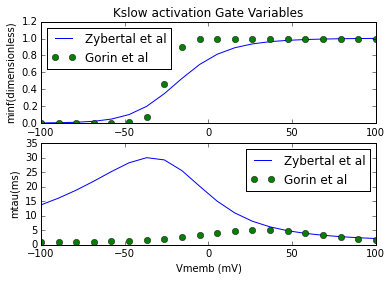

In [10]:
#load python packages
%pylab inline

#load equations
v = np.linspace(-100, 100, 20)
mtaueq = (1 + (4 * (np.exp(0 - np.square((v - 32)/50)))))
minf_fit = 1 / (1 + np.exp(0 - (v + 25.7)/4.4))

a=0.0052*(v-11.1)/(1-exp(-(v-11.1)/13.1))
b=0.01938*exp(-(v+1.27)/71)-0.0053
atau = 1/(a+b)
ainf = a/(a+b)

#plot Gate Variables
subplot(2,1,1)
plt.plot(v, ainf, v, minf_fit, 'o')
plt.ylabel('minf(dimensionless)')
plt.title('Kslow activation Gate Variables')
plt.legend(['Zybertal et al', 'Gorin et al'], loc='upper left')
subplot(2,1,2)
plt.plot(v, atau, v, mtaueq, 'o')
plt.xlabel('Vmemb (mV)')
plt.ylabel('mtau(ms)')
plt.legend(['Zybertal et al', 'Gorin et al'], loc='upper right')

Populating the interactive namespace from numpy and matplotlib


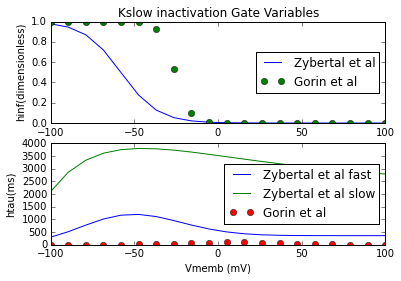

In [15]:
#load python packages
%pylab inline

#load equations
v = np.linspace(-100, 100, 20)
htaueq = (1 + (100 * (np.exp(0 - np.square((v - 10)/40)))))
hinf_fit = 1 / (1 + np.exp(0 - (v + 25.7)/-4.4))

taub = 360 + (1010+23.7*(v+54))*exp(-(v+75)*(v+75)/(48*48))
taub1=2350+1380*exp(-0.01118*v)-210*exp(-0.0306*v)
binf = 1/(1+exp(-(v+58)/-11))

#plot Gate Variables
subplot(2,1,1)
plt.plot(v, binf, v, hinf_fit, 'o')
plt.ylabel('hinf(dimensionless)')
plt.title('Kslow inactivation Gate Variables')
plt.legend(['Zybertal et al', 'Gorin et al'], loc='center right')
subplot(2,1,2)
plt.plot(v, taub, v, taub1, v, htaueq, 'o')
plt.xlabel('Vmemb (mV)')
plt.ylabel('htau(ms)')
plt.legend(['Zybertal et al fast', 'Zybertal et al slow','Gorin et al'], loc='center right')

##N-type Calcium Channel##
:n-type-like voltage gated calcium channel
:Migliore file Modify by Maciej Lazarewicz (mailto:mlazarew@gmu.edu) May/16/2001

TITLE n-calcium channel
: n-type calcium channel

UNITS {
	(mA) 	= 	(milliamp)
	(mV) 	= 	(millivolt)
	FARADAY =  	(faraday)  (kilocoulombs)
	R 	= 	(k-mole) (joule/degC)
	KTOMV 	= .0853 (mV/degC)
}

PARAMETER {
	v (mV)
	celsius	(degC)
    vshiftm = 0	(mV)		: voltage shift
    vshifth = 0	(mV)		: voltage shift
    timefactor_h = 1
    timefactor_m = 1
	gbar	= .0003 (mho/cm2)
	ki	= .001 	(mM)
	cai	= 5.e-5 (mM)
	cao 	= 10  	(mM)
}

STATE {	m h }

ASSIGNED {
	ica 		(mA/cm2)
    icont   (mA/cm2)
        gcan  		(mho/cm2) 
        minf
        hinf
        taum
        tauh
}

BREAKPOINT {
	SOLVE states METHOD cnexp
	gcan = gbar*m*m*h*h2(cai)
	ica  = gcan*ghk(v,cai,cao)
    icont = -ica
}

INITIAL {
	rates(v, vshiftm, vshifth)
	m = minf
	h = hinf
}

UNITSOFF
FUNCTION h2(cai(mM)) {
	h2 = ki/(ki+cai)
}

FUNCTION ghk(v(mV), ci(mM), co(mM)) (mV) {
        LOCAL nu,f

        f = KTF(celsius)/2
        nu = v/f
        ghk=-f*(1. - (ci/co)*exp(nu))*efun(nu)
}

FUNCTION KTF(celsius (degC)) (mV) {
        KTF = ((25./293.15)*(celsius + 273.15))
}


FUNCTION efun(z) {
	if (fabs(z) < 1e-4) {
		efun = 1 - z/2
	}else{
		efun = z/(exp(z) - 1)
	}
}

FUNCTION alph(v(mV)) {
	TABLE FROM -150 TO 1000 WITH 1600
	alph = 1.6e-4*exp(-v/48.4)
}

FUNCTION beth(v(mV)) {
        TABLE FROM -150 TO 1000 WITH 1600
	beth = 1/(exp((-v+39.0)/10.)+1.)
}

FUNCTION alpm(v(mV)) {
	TABLE FROM -150 TO 1000 WITH 1600
	alpm = 0.1967*(-1.0*v+19.88)/(exp((-1.0*v+19.88)/10.0)-1.0)
}

FUNCTION betm(v(mV)) {
	TABLE FROM -150 TO 1000 WITH 1600
	betm = 0.046*exp(-v/20.73)
}

UNITSON

DERIVATIVE states {     : exact when v held constant; integrates over dt step
        rates(v, vshiftm, vshifth)
        m' = (minf - m)/(taum*timefactor_m)
        h' = (hinf - h)/(tauh*timefactor_h)
}

PROCEDURE rates(v (mV), vshiftm (mV), vshifth (mV)) { :callable from hoc
        LOCAL a

        a    = alpm(v-vshiftm)
        taum = 1/(a + betm(v-vshiftm))
        minf = a*taum

        a    = alph(v-vshifth)
        tauh = 1/(a + beth(v-vshifth))
        hinf = a*tauh
}

Populating the interactive namespace from numpy and matplotlib


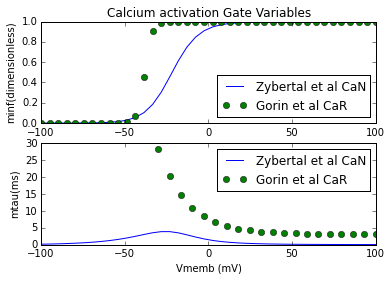

In [2]:
#load python packages
%pylab inline

#load equations
v = np.linspace(-100, 100, 40)
v1 = np.linspace(-30, 100, 20)
mtaueq = 3.1738 + (25.238 * (np.exp(-1 * ((v1+30)/17.498))))
minf_fit = 1 / (1 + np.exp(0 - (v + 38.037)/ 2.0914))

a = 0.1967*(-1.0*v+19.88)/(exp((-1.0*v+19.88)/10.0)-1.0)
b = 0.046*exp(-v/20.73)
taum = 1/(a + b)
minf = a*taum

#plot Gate Variables
subplot(2,1,1)
plt.plot(v, minf, v, minf_fit, 'o')
plt.ylabel('minf(dimensionless)')
plt.title('Calcium activation Gate Variables')
plt.legend(['Zybertal et al CaN', 'Gorin et al CaR'], loc='lower right')
subplot(2,1,2)
plt.plot(v, taum, v1, mtaueq, 'o')
plt.xlabel('Vmemb (mV)')
plt.ylabel('mtau(ms)')
plt.legend(['Zybertal et al CaN', 'Gorin et al CaR'], loc='upper right')

Populating the interactive namespace from numpy and matplotlib


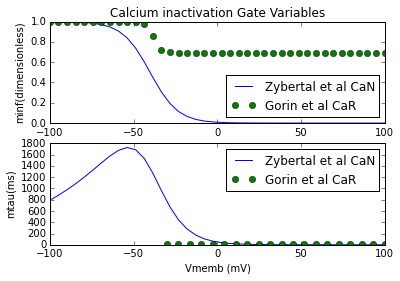

In [3]:
#load python packages
%pylab inline

#load equations
v = np.linspace(-100, 100, 40)
v1 = np.linspace(-30, 100, 20)
htaueq = 10.8 + (3.0 * (np.exp(-1 * ((v1+20)/8.13))))
hinf_fit = 1/(1+(np.exp(-1 * (v-(-38.037))/-2.0914))) + 0.6928/(1+(np.exp(-1 * (v-(-38.037))/2.0914)))

a = 1.6e-4*exp(-v/48.4)
b = 1/(exp((-v+39.0)/10.)+1.)
tauh = 1/(a + b)
hinf = a*tauh

#plot Gate Variables
subplot(2,1,1)
plt.plot(v, hinf, v, hinf_fit, 'o')
plt.ylabel('minf(dimensionless)')
plt.title('Calcium inactivation Gate Variables')
plt.legend(['Zybertal et al CaN', 'Gorin et al CaR'], loc='lower right')
subplot(2,1,2)
plt.plot(v, tauh, v1, htaueq, 'o')
plt.xlabel('Vmemb (mV)')
plt.ylabel('mtau(ms)')
plt.legend(['Zybertal et al CaN', 'Gorin et al CaR'], loc='upper right')

##Slow Ca-dependent cation current##
:
:   Ca++ dependent nonspecific cation current ICAN
:   Differential equations
:   http://senselab.med.yale.edu/modeldb/ShowModel.asp?model=144089


NEURON {
	SUFFIX ican_ns
	
	USEION ca READ cai VALENCE 2

    NONSPECIFIC_CURRENT i    
    RANGE gbar1, gbar2, i, g
    RANGE minf1, mtau1, minf2, mtau2
	GLOBAL Rb1, Rb2, caix, cac1, cac2, erev
}


UNITS {
	(mA) = (milliamp)
	(mV) = (millivolt)
	(molar) = (1/liter)
	(mM) = (millimolar)
}


PARAMETER {
	erev = -10	(mV)
	gbar1 = 1    (mho/cm2)
	gbar2 = 0    (mho/cm2)
    caix = 2
    cac1 = 1e-10 (mM)
    cac2 = 2e-10 (mM)

    
    
    Rb1 = 1   (/ms)
    Rb2 = 1   (/ms)
    

 
}


STATE {
	m1 m2
}

INITIAL {
    rates(cai)
    m1=minf1
    m2=minf2
}

ASSIGNED {
	i	(mA/cm2)
    
    v   (mV)	
	g       (mho/cm2)

    cai (mM)
    a1   (/ms)
    b1   (/ms)
    minf1
    mtau1    (ms)

    a2   (/ms)
    b2   (/ms)
    minf2
    mtau2    (ms)

}

BREAKPOINT { 
	SOLVE states METHOD cnexp
	g = gbar1 * m1 + gbar2 * m2

	i = g * (v - erev)
	
}

DERIVATIVE states { 
	
    rates(cai)
	m1' = (minf1 - m1) / mtau1
	m2' = (minf2 - m2) / mtau2
    
}

PROCEDURE rates(cai(mM)) {  

        

        if (cai>=0) {        
            a1 = Rb1 * (cai/cac1)^caix 
        }
        else {
            a1=0
        }

        b1 = Rb1

        mtau1 = 1/(a1+b1)
	    minf1 = a1/(a1+b1)

        if (cai>=0) {        
            a2 = Rb2 * (cai/cac2) 
        }
        else {
            a2=0
        }

        b2 = Rb2

        mtau2 = 1/(a2+b2)
	    minf2 = a2/(a2+b2)
 
}

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


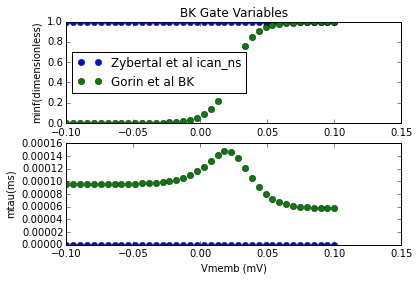

In [10]:
#load python packages
%pylab inline

#load equations
q10 = 3**((35 - 17.350264793)/10)
v = np.linspace(-0.100, 0.100, 40)
ca_conc = 5e-05#0.025
cai = 5e-05 #units mM
v1 = 0
alpha = 2500/(1 + ( (1.5e-3 *(np.exp(-85*v))) / ca_conc))
beta = 1500/(1 + (ca_conc / (1.5e-4 * (np.exp (-77*v)))))
mtaueq=1/( (alpha + beta)*q10)
minf_fit = alpha/(alpha + beta)
a1 = 1 * (cai/1e-10)**2
b1 = 1
minf = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
mtau = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
minf = minf*(a1/(a1+b1))
mtau = mtau*(1/(a1+b1))

#plot Gate Variables
subplot(2,1,1)
plt.plot(v, minf, 'o', v, minf_fit, 'o')
plt.ylabel('minf(dimensionless)')
plt.title('BK Gate Variables')
plt.legend(['Zybertal et al ican_ns', 'Gorin et al BK'], loc='center left')
subplot(2,1,2)
#plt.plot(vm[1], mtau[1])
plt.plot(v, mtau, 'o', v, mtaueq, 'o')
plt.xlabel('Vmemb (mV)')
plt.ylabel('mtau(ms)')
#plt.legend(['activation tau'], loc='upper left')
#plt.legend(['Zybertal et al ican_ns', 'Gorin et al BK'], loc='upper right')